# Import Packages

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sklearn.metrics as metrics

import utils

# Hyper-Parameters

In [3]:
DATASET_DIR = './data/'

BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 10

SaveModelName = "mobilenet_v3_large"

ModelSavePath = "./Saved_model/" + SaveModelName + "/"
if not os.path.isdir(ModelSavePath):
    os.mkdir(ModelSavePath)

USE_CUDA = torch.cuda.is_available() 
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") 
print("Working with", DEVICE)

Working with cuda


In [4]:
TRAIN_SET, TEST_SET, train_loader, test_loader = utils.load_dataset()

In [5]:
import torchvision.models as models
model_transfer = models.mobilenet_v3_large(pretrained=True)
n_dog_breed_classes = 120

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[3].in_features

last_layer = nn.Linear(n_inputs, n_dog_breed_classes)

model_transfer.classifier[3] = last_layer

In [6]:
model_name = ['mobilenet_v3_large']
models = [model_transfer.to(DEVICE)]
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [7]:
LOSSES_TRAIN, LOSSES_VAL = [[] for idx in range(len(models))], [[] for idx in range(len(models))]
ACCS_VAL = [[] for idx in range(len(models))]
SOTA_ACCS_VAL, SOTA_LOSS_VAL = [0 for idx in range(len(models))], [0 for idx in range(len(models))]
bestResult_pred_np, bestResult_anno_np = [[] for idx in range(len(models))], [[] for idx in range(len(models))]
bestModels = [0 for idx in range(len(models))]

for model_idx, model in enumerate(models):
    start = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in tqdm(range(EPOCHS), desc="EPOCHS"):
        model.train()
        LOSS_TRACE_FOR_TRAIN, LOSS_TRACE_FOR_VAL = [], []
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            X_train, Y_train = batch
            X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)

            Y_pred_train = model(X_train)
            Y_train = Y_train.squeeze(-1)

            LOSS_train = criterion(Y_pred_train, Y_train)

            LOSS_TRACE_FOR_TRAIN.append(LOSS_train.cpu().detach().numpy())
            LOSS_train.backward()
            optimizer.step()        

        with torch.no_grad():
            model.eval()
            Result_pred_val, Result_anno_val = [], []
            for idx, batch in enumerate(test_loader):
                X_val, Y_val = batch
                X_val, Y_val = X_val.to(DEVICE), Y_val.to(DEVICE)

                Y_pred_val = model(X_val)
                LOSS_val = criterion(Y_pred_val, Y_val)
                LOSS_TRACE_FOR_VAL.append(LOSS_val.cpu().detach().numpy())

                Y_pred_val_np  = Y_pred_val.to('cpu').detach().numpy()
                Y_pred_val_np  = np.argmax(Y_pred_val_np, axis=1).squeeze()
                Y_val_np       = Y_val.to('cpu').detach().numpy().reshape(-1, 1).squeeze()     
                
                Result_pred_val = np.hstack((Result_pred_val, Y_pred_val_np))
                Result_anno_val = np.hstack((Result_anno_val, Y_val_np))
                # Result_pred_val.append(list(Y_pred_val_np))
                # Result_anno_val.append(list(Y_val_np))
            
            Result_pred_np = np.array(Result_pred_val)
            Result_anno_np = np.array(Result_anno_val)
            Result_pred_np = np.reshape(Result_pred_np, (-1, 1))
            Result_anno_np = np.reshape(Result_anno_np, (-1, 1))
            
            ACC_VAL        = metrics.accuracy_score(Result_anno_np, Result_pred_np)
            AVG_LOSS_TRAIN = np.average(LOSS_TRACE_FOR_TRAIN)
            AVG_LOSS_VAL   = np.average(LOSS_TRACE_FOR_VAL)

            LOSSES_TRAIN[model_idx].append(AVG_LOSS_TRAIN)
            LOSSES_VAL[model_idx].append(AVG_LOSS_VAL)
            ACCS_VAL[model_idx].append(ACC_VAL)
            
            if ACC_VAL > SOTA_ACCS_VAL[model_idx]:
                SOTA_ACCS_VAL[model_idx] = ACC_VAL
                SOTA_LOSS_VAL[model_idx] = AVG_LOSS_VAL
                bestModels[model_idx] = model
                bestResult_pred_np[model_idx] = Result_pred_np
                bestResult_anno_np[model_idx] = Result_anno_np
                
            elif ACC_VAL == SOTA_ACCS_VAL[model_idx]:
                if AVG_LOSS_VAL < SOTA_LOSS_VAL[model_idx]:
                    SOTA_ACCS_VAL[model_idx] = ACC_VAL
                    SOTA_LOSS_VAL[model_idx] = AVG_LOSS_VAL
                    bestModels[model_idx] = model
                    bestResult_pred_np[model_idx] = Result_pred_np
                    bestResult_anno_np[model_idx] = Result_anno_np
                
            print(f'(epoch {epoch + 1:03d}/{EPOCHS}) Training Loss : {AVG_LOSS_TRAIN:.5f} | Validation Loss : {AVG_LOSS_VAL:.5f} | Validation Accuracy : {ACC_VAL*100:.2f} %')

    end = time.time()
    print(f"{model_name[model_idx]} Training took {end-start:.2f} sec")
    torch.save(bestModels[model_idx].state_dict(), ModelSavePath + model_name[model_idx] +'.pth')

EPOCHS:   0%|          | 0/10 [00:00<?, ?it/s]

(epoch 001/10) Training Loss : 2.60077 | Validation Loss : 1.38541 | Validation Accuracy : 60.54 %
(epoch 002/10) Training Loss : 1.55597 | Validation Loss : 1.26569 | Validation Accuracy : 64.71 %
(epoch 003/10) Training Loss : 1.36371 | Validation Loss : 1.28258 | Validation Accuracy : 63.80 %
(epoch 004/10) Training Loss : 1.27933 | Validation Loss : 1.39329 | Validation Accuracy : 61.76 %
(epoch 005/10) Training Loss : 1.19449 | Validation Loss : 1.29053 | Validation Accuracy : 64.49 %
(epoch 006/10) Training Loss : 1.12052 | Validation Loss : 1.35562 | Validation Accuracy : 63.19 %
(epoch 007/10) Training Loss : 1.06676 | Validation Loss : 1.38914 | Validation Accuracy : 62.06 %
(epoch 008/10) Training Loss : 1.03742 | Validation Loss : 1.37101 | Validation Accuracy : 62.57 %
(epoch 009/10) Training Loss : 1.00707 | Validation Loss : 1.34443 | Validation Accuracy : 62.40 %
(epoch 010/10) Training Loss : 0.96389 | Validation Loss : 1.34606 | Validation Accuracy : 63.04 %
mobilenet_

(4072, 1)
(4072, 1)
0.6471021611001965
[[37  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 31 ...  0  0  0]
 ...
 [ 0  0  0 ... 21  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  2 ...  0  0 22]]
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83        47
         1.0       0.68      0.91      0.78        33
         2.0       0.79      0.78      0.78        40
         3.0       1.00      0.16      0.27        32
         4.0       0.52      0.40      0.45        30
         5.0       0.77      0.62      0.69        39
         6.0       0.85      0.81      0.83        36
         7.0       0.76      0.65      0.70        43
         8.0       0.71      0.86      0.78        37
         9.0       0.45      0.73      0.56        30
        10.0       0.74      0.82      0.78        34
        11.0       0.74      0.69      0.71        36
        12.0       0.48      0.70      0.57        30
        13.0       0.88      0.77      0.82     

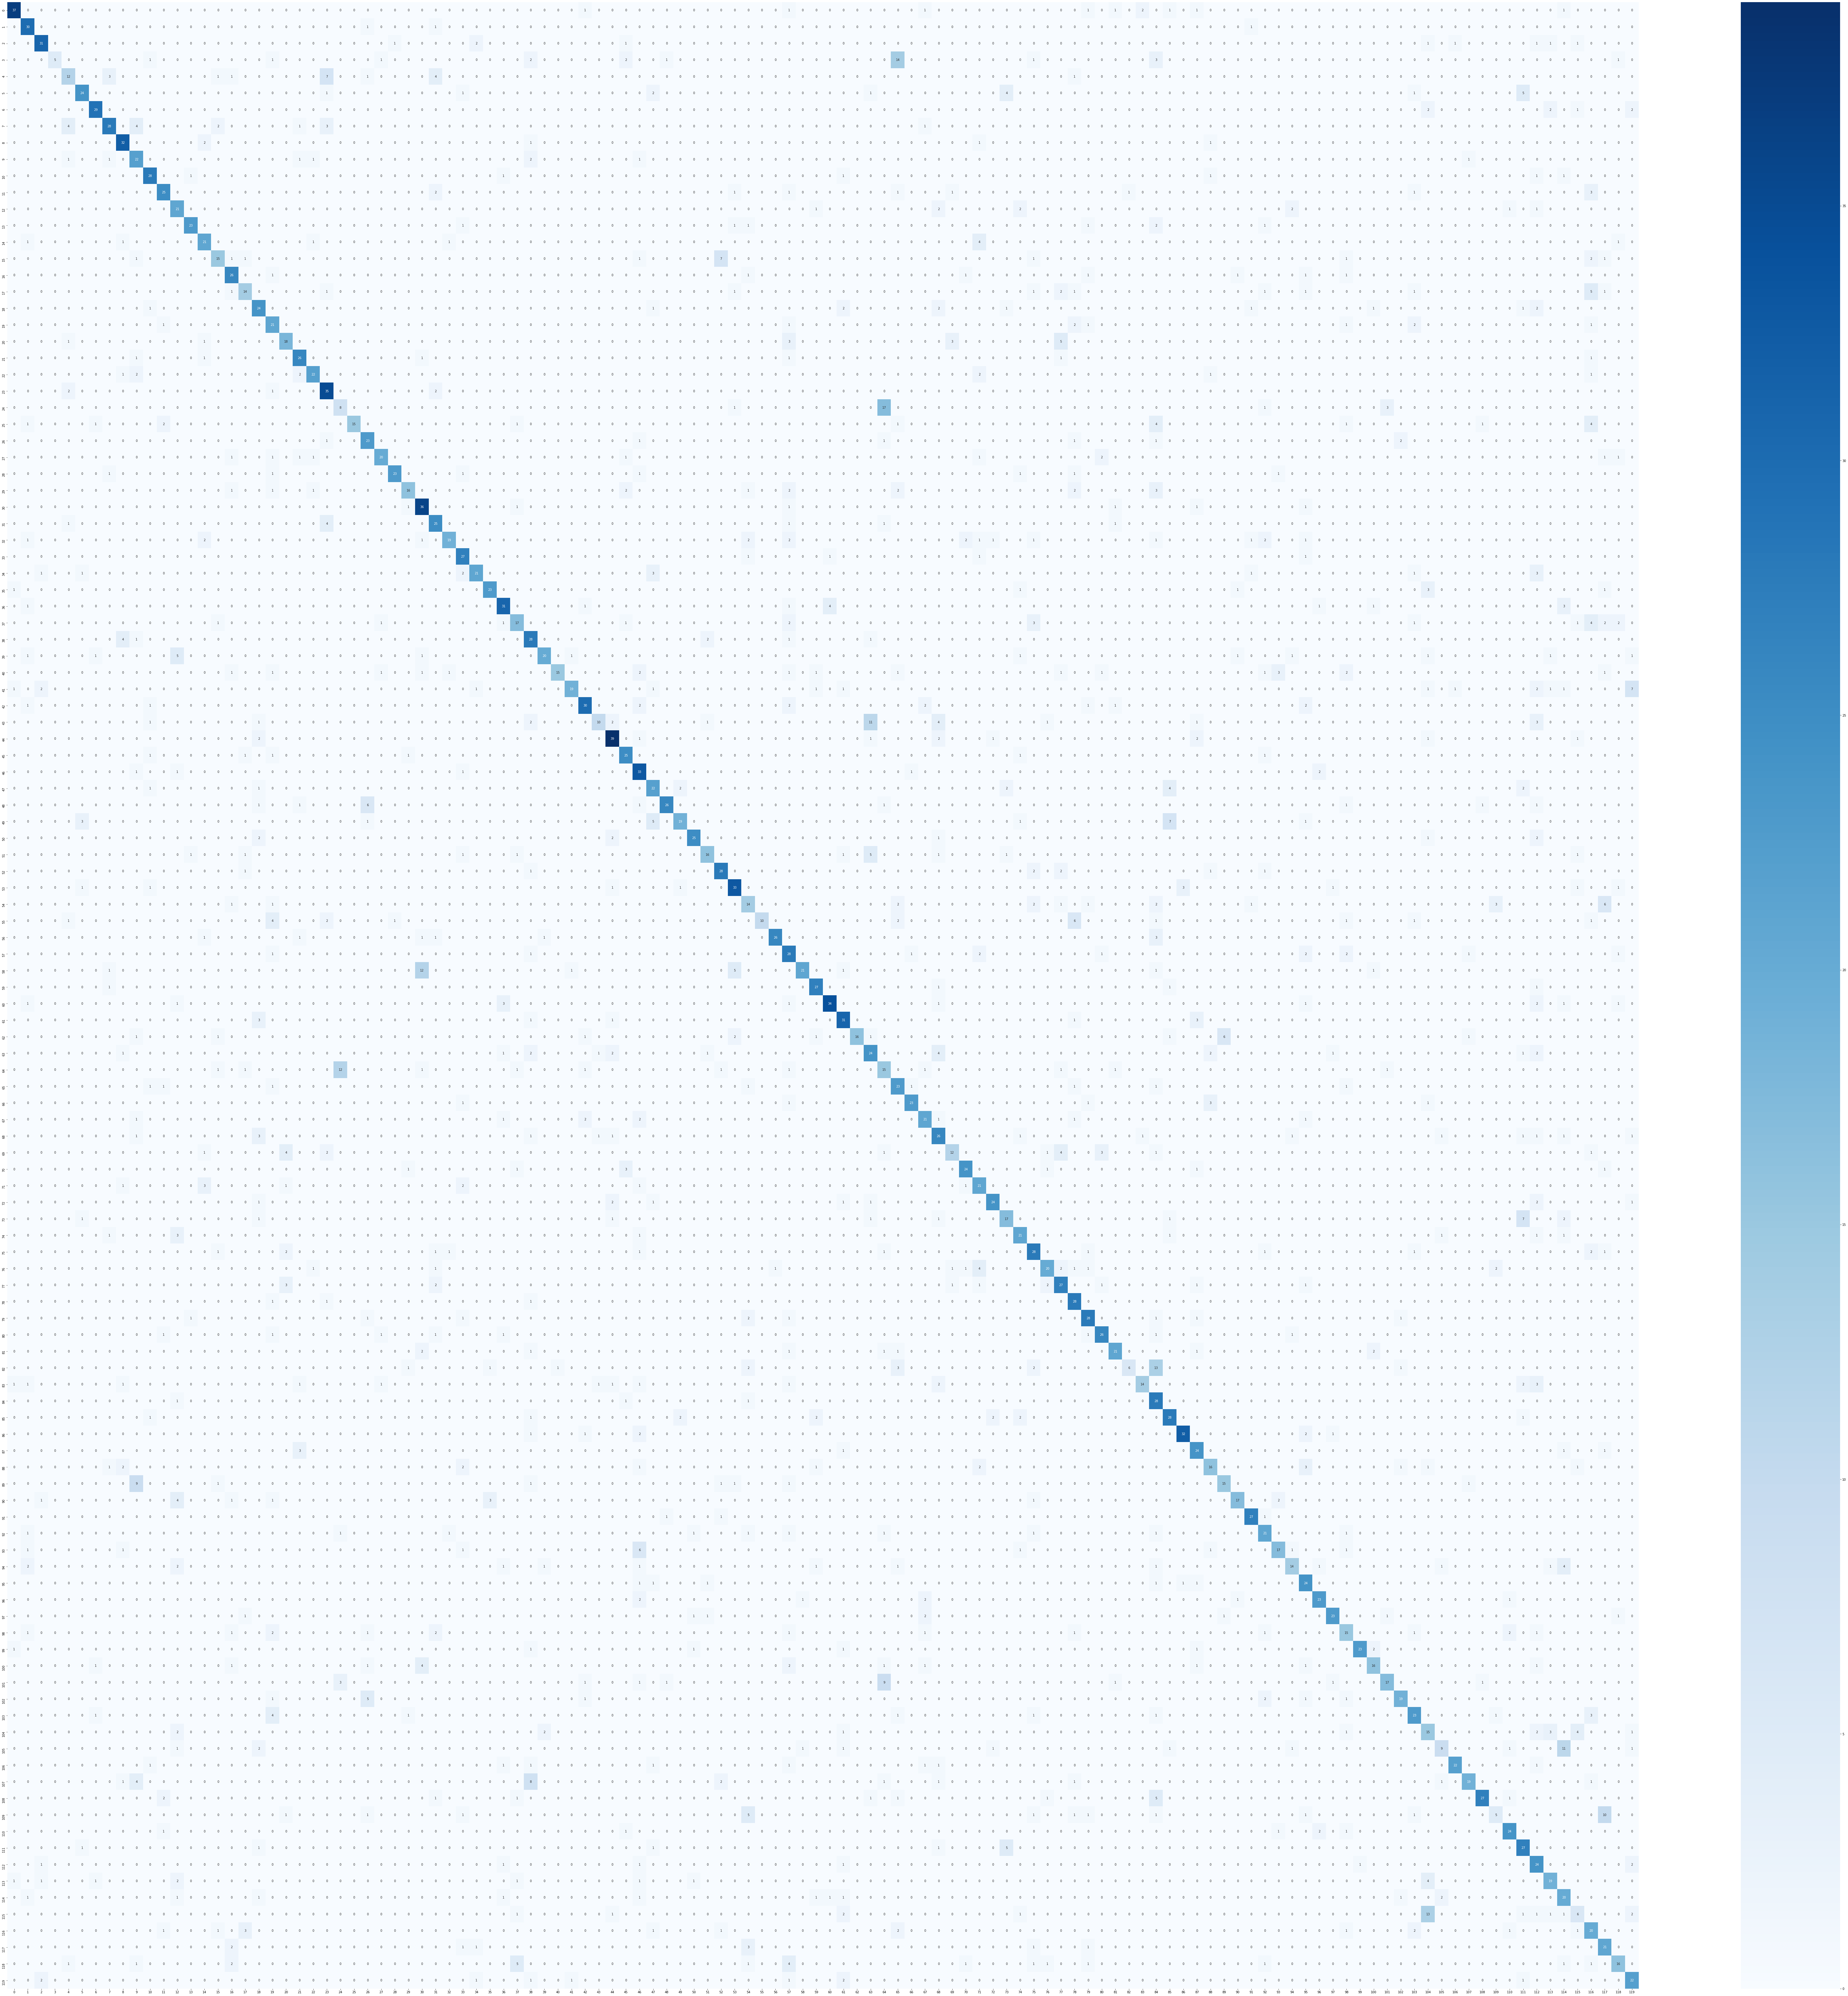

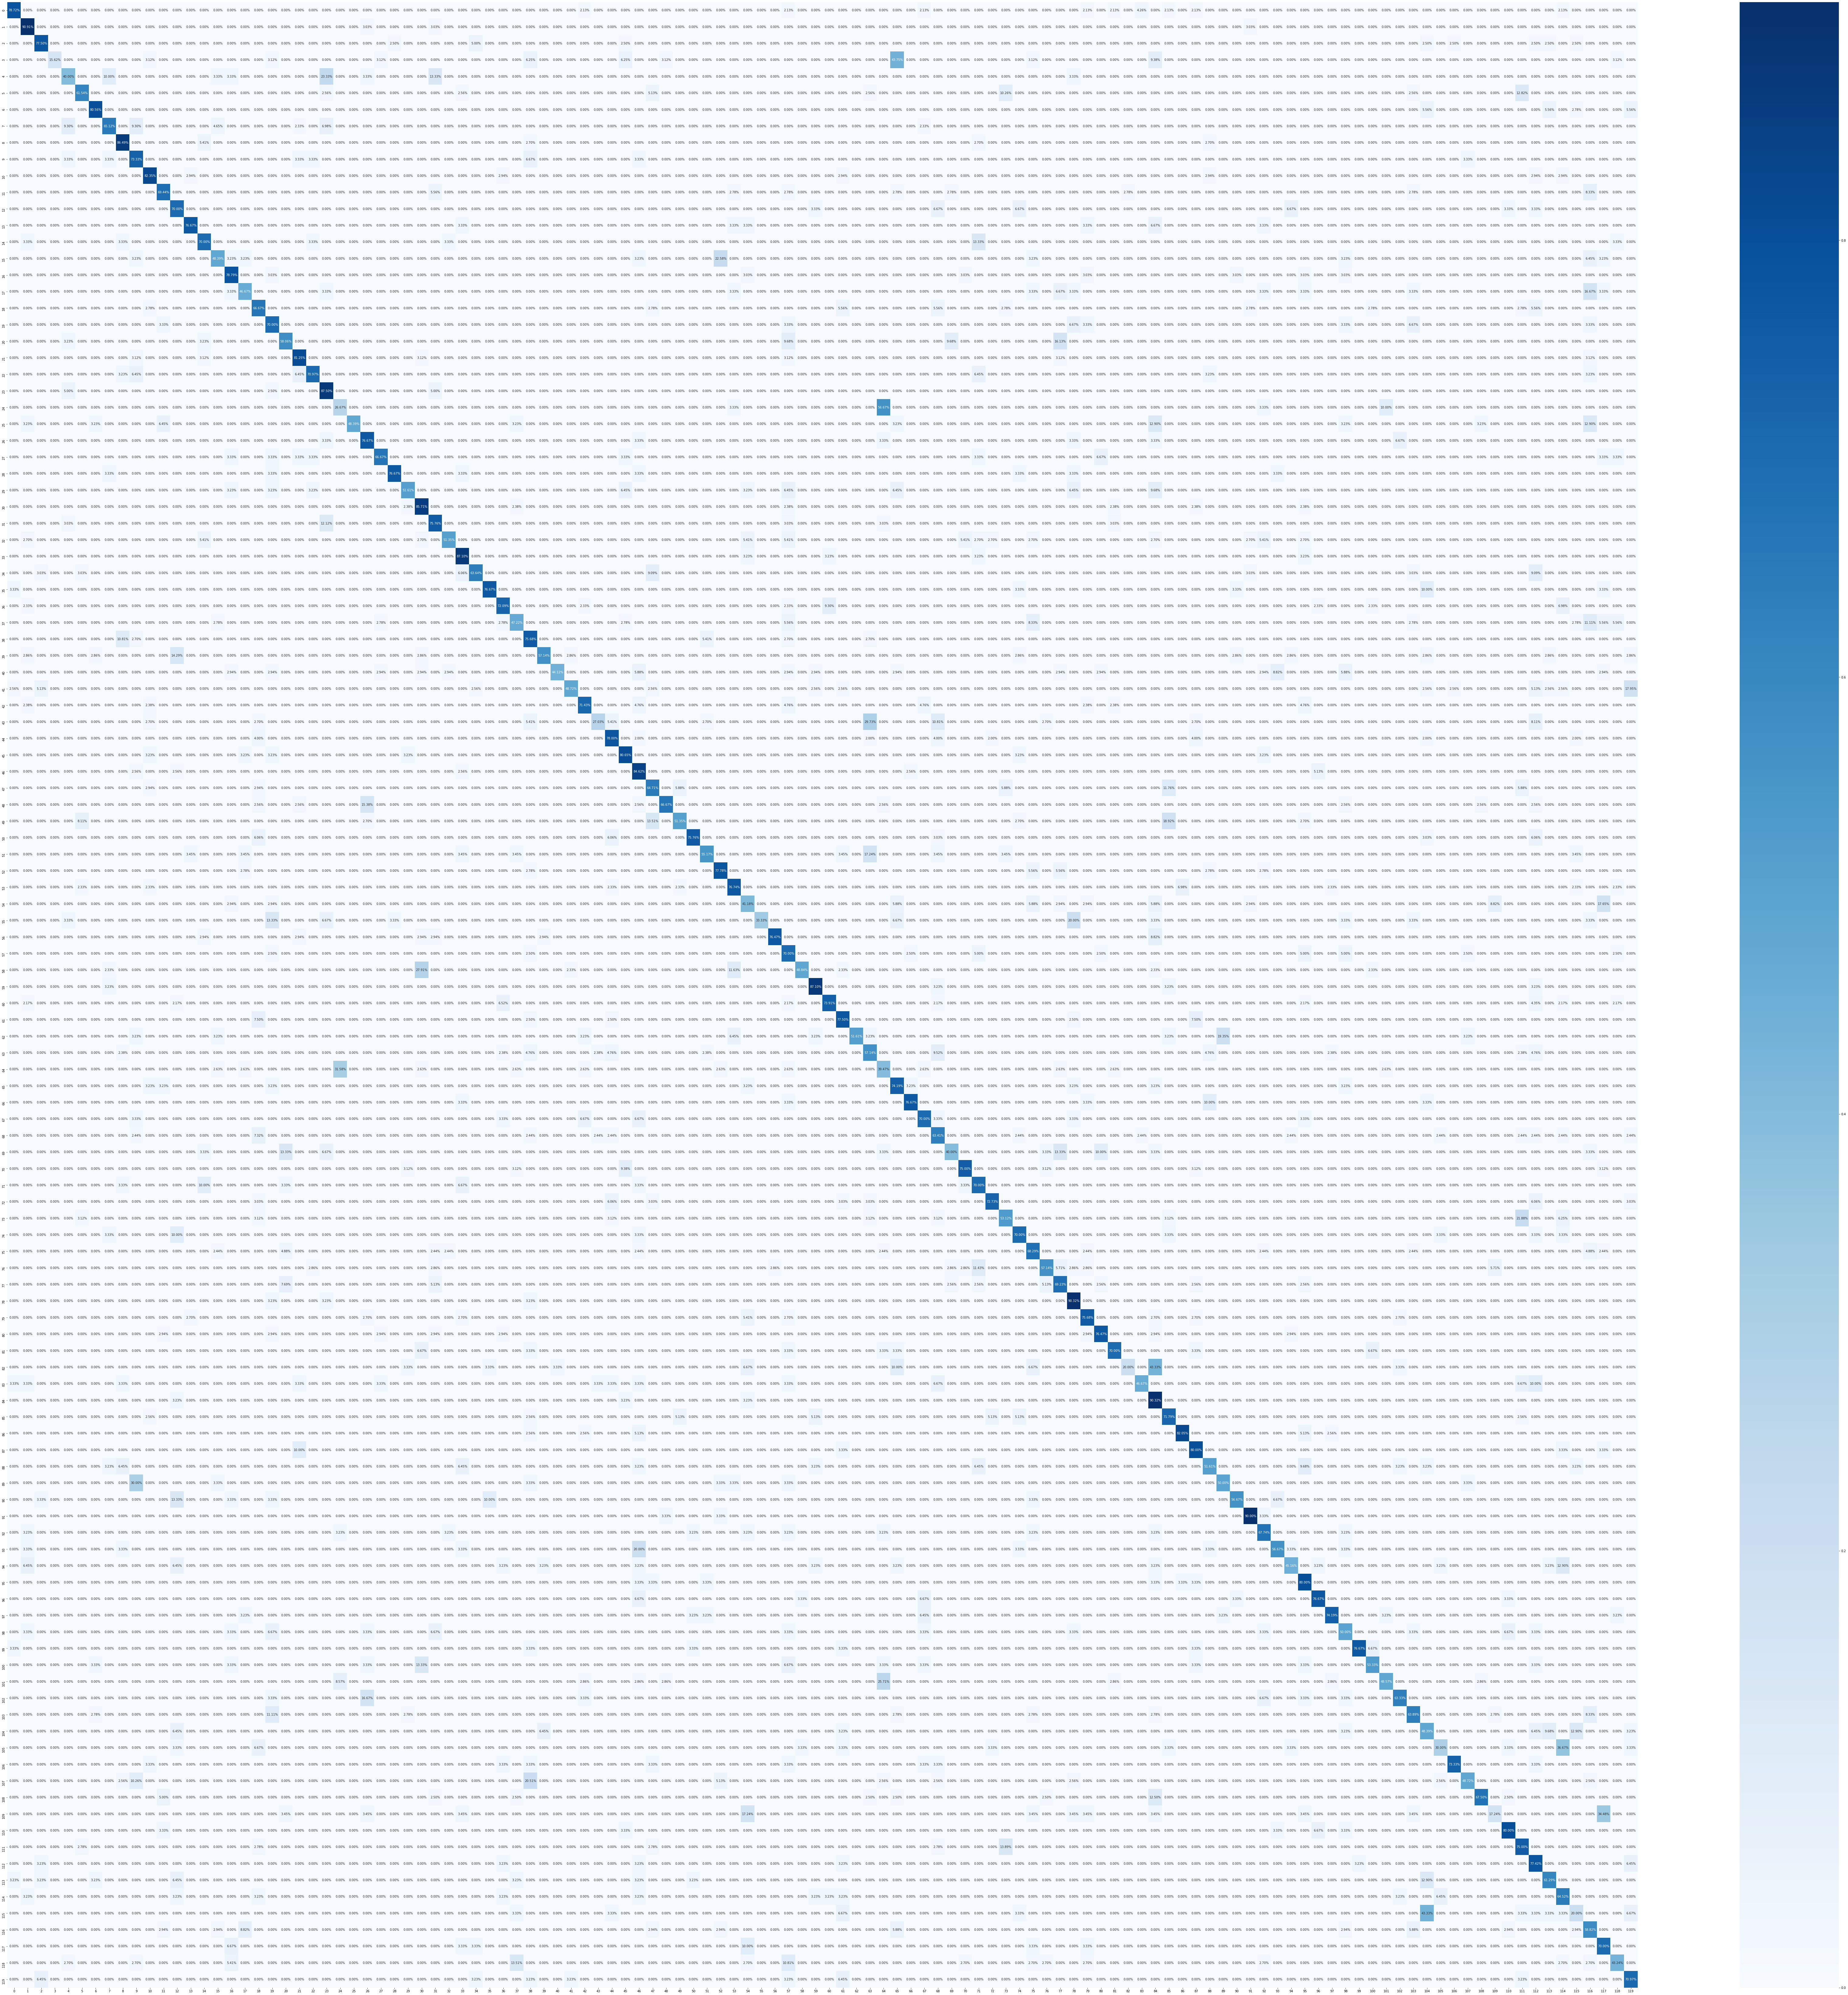

In [8]:
utils.get_metrics(models = models, pred = bestResult_pred_np, anno = bestResult_anno_np)